In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape,Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [4]:
# Height and width refer to the size of the image
# Channels refers to the amount of color channels (red, green, blue)

image_dimensions = {'height':256, 'width':256, 'channels':3}

In [5]:
# Create a Classifier class

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

In [6]:
# Create a MesoNet class using the Classifier

class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer,
                           loss = 'mean_squared_error',
                           metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return Model(inputs = x, outputs = y)

In [7]:
# Instantiate a MesoNet model with pretrained weights
meso = Meso4()
meso.load('./weights/Meso4_DF')

In [8]:
# Prepare image data

# Rescaling pixel values (between 1 and 255) to a range between 0 and 1
dataGenerator = ImageDataGenerator(rescale=1./255)

# Instantiating generator to feed images through the network
generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 2041 images belonging to 2 classes.


In [9]:
# Checking class assignment
generator.class_indices

{'DeepFake': 0, 'Real': 1}

In [10]:
# '.ipynb_checkpoints' is a *hidden* file Jupyter creates for autosaves
# It must be removed for flow_from_directory to work.
!rmdir /s /q c:data\.ipynb_checkpoints

# Equivalent command in Unix (for Mac / Linux users)
# !rm -r /Users/mikhaillenko/mesonet/mesonet/data/.ipynb_checkpoints/

The system cannot find the file specified.


In [11]:
import scipy

In [12]:
# Recreating generator after removing '.ipynb_checkpoints'
dataGenerator = ImageDataGenerator(rescale=1./255)

generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

# Re-checking class assignment after removing it
generator.class_indices

Found 2041 images belonging to 2 classes.


{'DeepFake': 0, 'Real': 1}

1/1 [==============================] - 2s 2s/step
Predicted likelihood: 0.9920
Actual label: 1
1/1 [==============================] - 0s 272ms/step

Correct prediction: True


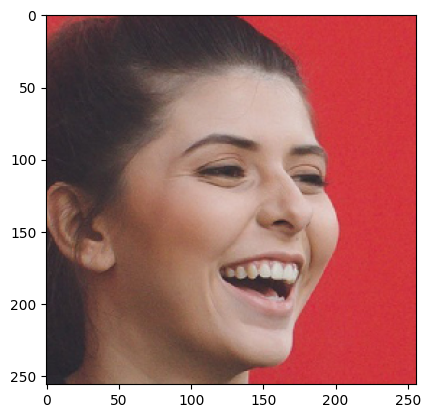

In [13]:
# Rendering image X with label y for MesoNet
X, y = generator.next()

# Evaluating prediction
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X));

In [14]:
# Creating separate lists for correctly classified and misclassified images
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [15]:
# Generating predictions on validation set, storing in separate lists
for i in range(len(generator.labels)):
    
    # Loading next picture, generating prediction
    X, y = generator.next()
    pred = meso.predict(X)[0][0]
    
    # Sorting into proper category
    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)   
        
    # Printing status update
    if i % 1000 == 0:
        print(i, ' predictions completed.')
    
    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")

1/1 [==============================] - 0s 251ms/step
0  predictions completed.
1/1 [==============================] - 0s 114ms/step
1000  predictions completed.
1/1 [==============================] - 0s 91ms/step
2000  predictions completed.
1/1 [==============================] - 0s 86ms/step
All 2041 predictions completed


In [16]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

C:\Users\parak\AppData\Local\Temp\ipykernel_9512\2891497696.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


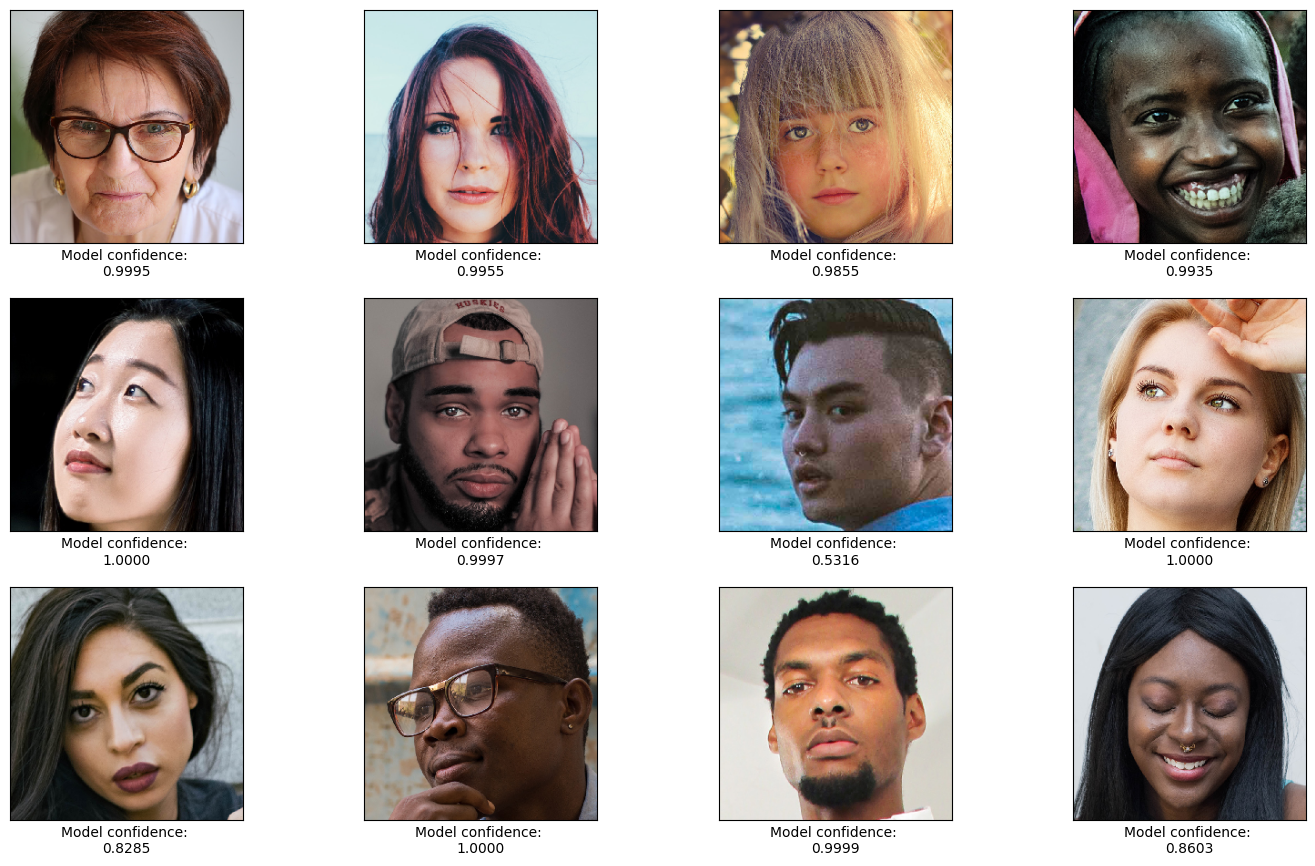

In [17]:
plotter(correct_real, correct_real_pred)

C:\Users\parak\AppData\Local\Temp\ipykernel_9512\2891497696.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


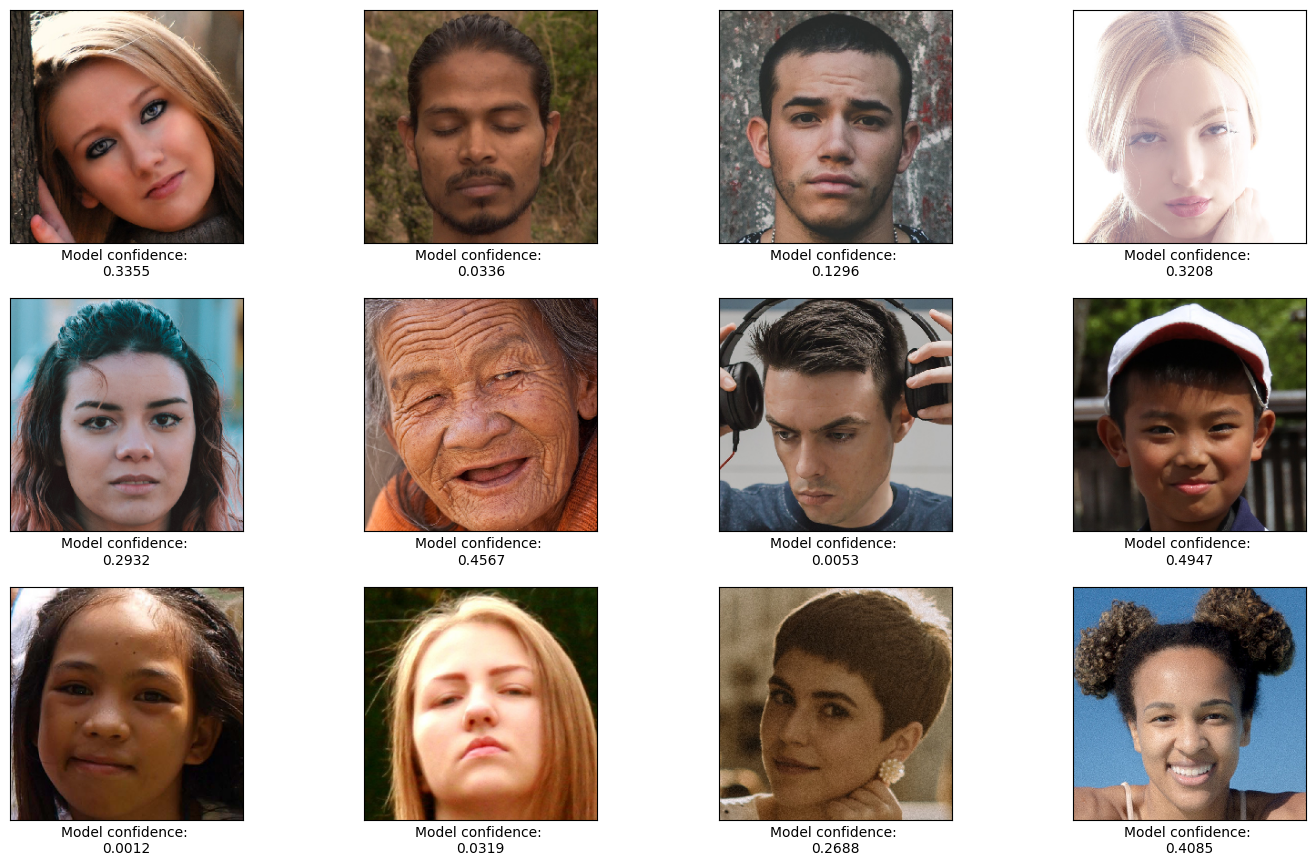

In [18]:
plotter(misclassified_real, misclassified_real_pred)

C:\Users\parak\AppData\Local\Temp\ipykernel_9512\2891497696.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


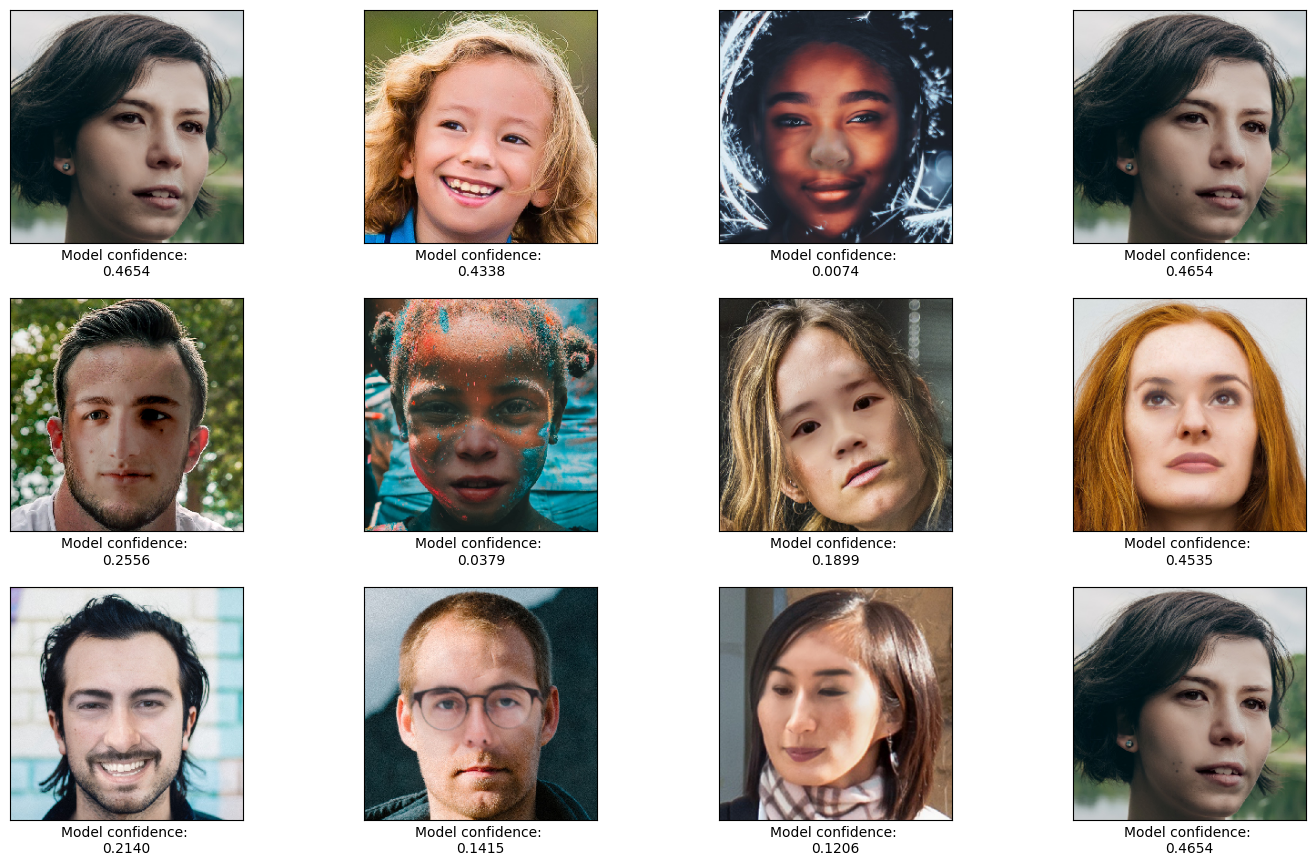

In [19]:
plotter(correct_deepfake, correct_deepfake_pred)

C:\Users\parak\AppData\Local\Temp\ipykernel_9512\2891497696.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


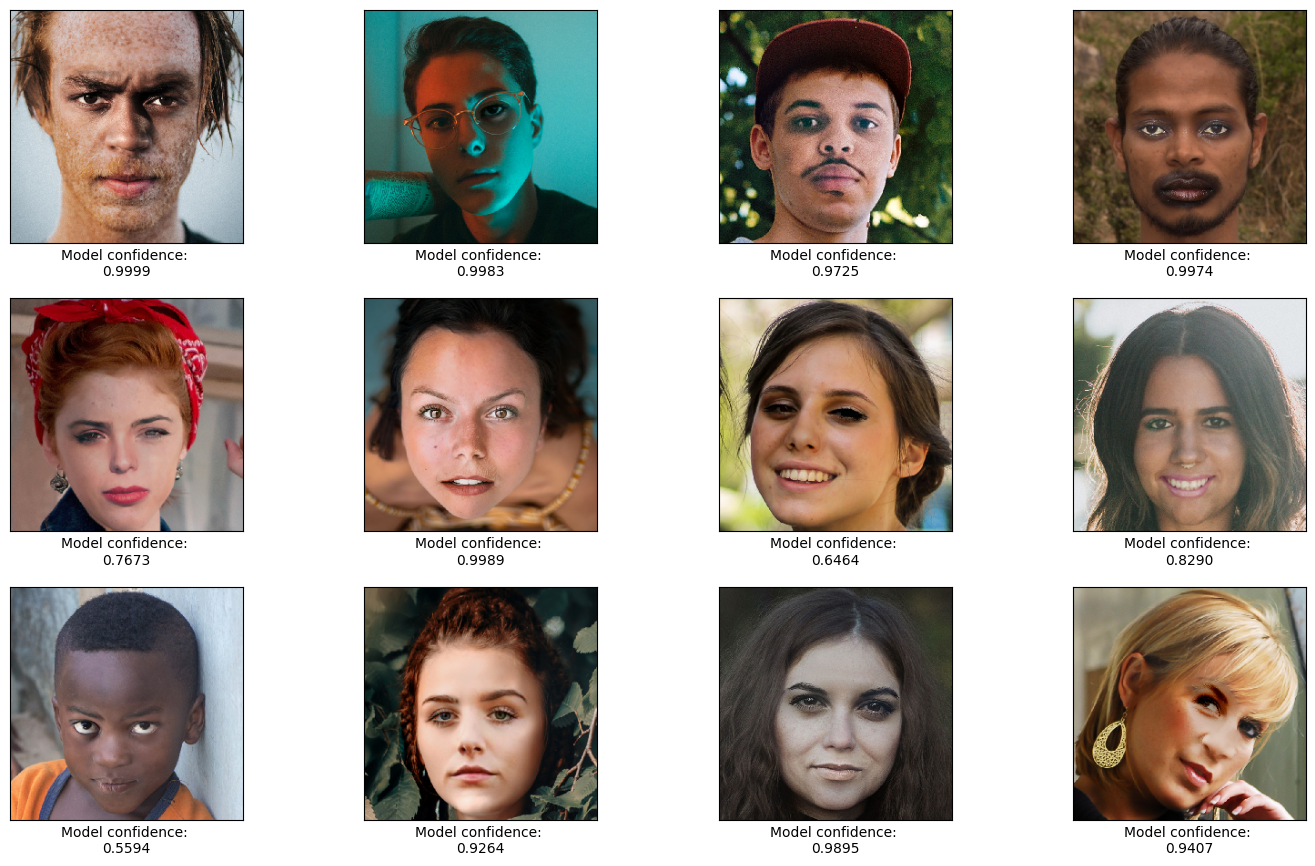

In [20]:
plotter(misclassified_deepfake, misclassified_deepfake_pred)

In [21]:
# VIDEO THING #

# import cv2
# import dlib

# # Load pre-trained face detection model from dlib
# detector = dlib.get_frontal_face_detector()

# # Open the video file
# video_path = 'path_to_video.mp4'
# cap = cv2.VideoCapture(video_path)

# # Initialize variables for frame count and fake/real score
# frame_count = 0
# fake_score = 0  # You can use this variable to accumulate a score for fake frames

# while True:
#     ret, frame = cap.read()
    
#     if not ret:
#         break
    
#     frame_count += 1

#     # Convert the frame to grayscale for face detection
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     # Detect faces in the frame
#     faces = detector(gray)

#     # If no faces are detected, continue to the next frame
#     if len(faces) == 0:
#         continue

#     # Here, you can implement additional analysis of facial features,
#     # expressions, or movements to compute a fake/real score for each frame.

#     # For simplicity, let's assume a frame is fake if any face is detected.
#     fake_score += 1

# # Calculate the percentage of frames classified as fake
# fake_percentage = (fake_score / frame_count) * 100

# # Define a threshold for classifying the video as fake or real
# threshold = 50  # Adjust as needed

# # Classify the video based on the threshold
# if fake_percentage > threshold:
#     result = "Fake"
# else:
#     result = "Real"

# print(f"Video is {result} with a fake percentage of {fake_percentage:.2f}%")

# # Release video capture object and close any OpenCV windows
# cap.release()
# cv2.destroyAllWindows()


In [22]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Height and width refer to the size of the image
# Channels refers to the amount of color channels (red, green, blue)
image_dimensions = {'height': 256, 'width': 256, 'channels': 3}

# Create a MesoNet class for image classification
class Meso4:
    def __init__(self, model_path='./weights/Meso4_DF'):
        self.model = self.init_model()
        self.model.load_weights(model_path)
    
    def init_model(self):
        x = Input(shape=(image_dimensions['height'],
                         image_dimensions['width'],
                         image_dimensions['channels']))

        x1 = Conv2D(8, (3, 3), padding='same', activation='relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

        x2 = Conv2D(8, (5, 5), padding='same', activation='relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

        x3 = Conv2D(16, (5, 5), padding='same', activation='relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

        x4 = Conv2D(16, (5, 5), padding='same', activation='relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation='sigmoid')(y)

        return Model(inputs=x, outputs=y)

    def predict_image(self, image_path):
        img = image.load_img(image_path, target_size=(image_dimensions['height'], image_dimensions['width']))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img /= 255.0  # Normalize pixel values between 0 and 1
        confidence = self.model.predict(img)[0][0]
        return confidence * 100  # Convert to percentage

    def classify_image(self, image_path, threshold=50):
        confidence = self.predict_image(image_path)
        if confidence > threshold:
            return "Real"
        else:
            return "Fake"

# Instantiate the MesoNet model with pretrained weights
meso = Meso4()

# Test the model on a single image and classify it
image_path = r'C:\Users\parak\Desktop\DeepFake-detection-application\Deepfake-detection\data\DeepFake\mid_467_1111.jpg'  # Replace with the path to your test image
classification = meso.classify_image(image_path)
print(f"Image is {classification}")


1/1 [==============================] - 2s 2s/step
Image is Real


In [3]:
pip install opencv-python


     ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
     ---------------------------------------- 0.1/38.1 MB 2.6 MB/s eta 0:00:15
     ---------------------------------------- 0.2/38.1 MB 3.0 MB/s eta 0:00:13
     ---------------------------------------- 0.3/38.1 MB 2.7 MB/s eta 0:00:14
     ---------------------------------------- 0.4/38.1 MB 2.0 MB/s eta 0:00:20
     ---------------------------------------- 0.4/38.1 MB 2.0 MB/s eta 0:00:20
     ---------------------------------------- 0.4/38.1 MB 1.6 MB/s eta 0:00:24
     ---------------------------------------- 0.5/38.1 MB 1.4 MB/s eta 0:00:27
      --------------------------------------- 0.5/38.1 MB 1.5 MB/s eta 0:00:26
      --------------------------------------- 0.6/38.1 MB 1.5 MB/s eta 0:00:26
      --------------------------------------- 0.7/38.1 MB 1.4 MB/s eta 0:00:27
      --------------------------------------- 0.7/38.1 MB 1.4 MB/s eta 0:00:27
      --------------------------------------- 0.8/38.1 MB 


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import cv2
import os
import time

# Read the video from specified path
cap = cv2.VideoCapture(r"C:\Users\parak\Desktop\keep\Innovations\Project demo video.mp4")

# Creating a folder named data if not created then raise error
if not os.path.exists('screenshots'):
    os.makedirs('screenshots')

# currentframe
currentframe = 0

while (True):

    # Capture frame-by-frame
    ret, frame = cap.read()

    # if video is still left continue creating images
    if ret:

        # name of each frame
        name = './screenshots/frame' + str(currentframe) + '.jpg'

        # writing the extracted images
        cv2.imwrite(name, frame)

        # increasing counter so that it will show how many frames are created
        currentframe += 1

    else:
        break

# Release all space and windows once done
cap.release()
cv2.destroyAllWindows()
